In [1]:
from typing import Iterator
from torch.nn.parameter import Parameter
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithm.fedprob_utils.smooth import Smooth
import utils.fflow as flw
import torch
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import ujson
import random
import json
import pickle as pk



In [2]:

# Settings
# fedtask = "cifar10_cnum100_dist8_skew0.1_seed0"
record_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist8_skew0.1_seed0/record/fedprob_N_0.25Mresnet18_R600_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json'
# model_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist8_skew0.1_seed0/record/fedprob_N_0.25Mresnet18_R300_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json.pkl'
record = json.load(open(record_path, "r", encoding="utf-8"))
options = record['meta']

options['gpu'] = -1
options['server_gpu_id'] = -1

# load server
# read options
os.environ['MASTER_ADDR'] = "localhost"
os.environ['MASTER_PORT'] = '8888'
os.environ['WORLD_SIZE'] = str(3)
# set random seed   
flw.setup_seed(options['seed'])
# initialize server
server = flw.initialize(options)


init fedtask...done
init clients...done
init server...done


In [5]:
num_classes = 10
num_clients = 100 

In [6]:
server_labels = []
client_labels = {}
num_client = 0
client_class_num = np.zeros((num_classes,))
cnum_client = []

for X, Y in server.test_data:
    server_labels.append(Y)
for client in server.clients:
    client_labels[client.name] = []
    for X, Y in client.valid_data:
        client_labels[client.name].append(Y.item())
    num_client += len(client_labels[client.name])
    class_num, bins = np.histogram(client_labels[client.name], range=[0, num_classes], bins=range(num_classes + 1))
    
    cnum_client.append(class_num)
    client_class_num += class_num

num_server = len(server_labels)

server_class_num, bins = np.histogram(server_labels)

In [7]:
per_client_accuracy = [np.array(record['client_certify_acc'][client_name]) for client_name in record['client_certify_acc'].keys()]
per_client_accuracy = np.array(per_client_accuracy).T

In [8]:
# A.shape : k * n 
A = np.array(cnum_client)
client_vols = A.sum(axis=1)
client_sort = (-client_vols).argsort()
# save A to file 
np.save('A_dis8_skew0.1_cifar10.npy', A)


In [67]:
Pd.shape

torch.Size([50, 100])

In [91]:
import torch 

# load numpy array from A.npy file
A = np.load('./A1.npy')

# convert numpy array to torch tensor
A = torch.from_numpy(A)
Pd = A / A.sum(axis=1, keepdims=True)
Ps = torch.ones((num_classes, 1)) * (1.0 / num_classes)
v = torch.ones((1) )
# x = torch.randn((num_clients, 1), requires_grad = True)
u = torch.ones((num_clients, 1)) 
# u2 = torch.randn((num_clients, 1), requires_grad = True) 

# A 50 * 100 
# x_best is the value of x that minimizes the objective function lag 

# x_best = 0.5 * torch.inverse(Pd@Pd.T) @ (2*Pd@Ps + u - v * torch.ones((num_clients, 1)))   
# lag = torch.linalg.vector_norm(A.T @ x_best - Ps)**2 - u.T @ x_best + v * (1 - torch.ones((1, num_clients)) @ x_best)


def lag(x, u, v) : 
    return torch.linalg.vector_norm(A.T @ x - Ps)**2 - u.T @ x + v * (1 - torch.ones((1, num_clients)) @ x)

def neg_lag(x, u, v): 
    return -lag(x, u, v)

In [69]:
# count the number of elements in u that are negative
def count_neg(u):
    return torch.sum(u < 0)

In [70]:
# Find the optimal value of u,v that maximizes the min value of lag over x by gradient descent
# lag = torch.linalg.vector_norm(A.T @ x - Ps)**2 - u.T @ x + v * (1 - torch.ones((1, num_clients)) @ x)

u.requires_grad = True
v.requires_grad = True 

for i in range(10000):
    optimizer = torch.optim.Adam([u, v], lr=0.0001)
    optimizer.zero_grad()
    x_best = 0.5 * torch.inverse(Pd@Pd.T) @ (2*Pd@Ps + u - v * torch.ones((num_clients, 1)))   
    # lag = - (torch.linalg.vector_norm(A.T @ x_best - Ps)**2 - u.T @ x_best + v * (1 - torch.ones((1, num_clients)) @ x_best)) 
    loss = neg_lag(x_best, u, v)
     
    loss.backward()
    optimizer.step()
    print(loss.item(), " count_u:", count_neg(u).item(), " v:" ,v.item())
    if count_neg(u) > 0: 
        break


-946.0404052734375  count_u: 0  v: 0.9998999834060669
-105.93267059326172  count_u: 0  v: 1.0
-2018.1602783203125  count_u: 0  v: 0.9998999834060669
-1833.174560546875  count_u: 0  v: 0.9997999668121338
-6018.44091796875  count_u: 0  v: 0.9998999834060669
-4328.52099609375  count_u: 0  v: 0.9997999668121338
-12692.38671875  count_u: 0  v: 0.9996999502182007
-7522.81689453125  count_u: 0  v: 0.9995999336242676
-13360.06640625  count_u: 0  v: 0.9994999170303345
-14449.7353515625  count_u: 0  v: 0.9993999004364014
-30740.48828125  count_u: 0  v: 0.9992998838424683
-18028.751953125  count_u: 0  v: 0.9991998672485352
-25696.634765625  count_u: 0  v: 0.999099850654602
-51882.08984375  count_u: 0  v: 0.9991998672485352
-48638.83984375  count_u: 0  v: 0.999099850654602
-31525.87109375  count_u: 0  v: 0.998999834060669
-55371.7890625  count_u: 0  v: 0.9988998174667358
-74968.1171875  count_u: 0  v: 0.998999834060669
-55398.8203125  count_u: 0  v: 0.9988998174667358
-80951.28125  count_u: 0  v: 

KeyboardInterrupt: 

In [53]:
x_best.sum()

tensor(-0.1035, grad_fn=<SumBackward0>)

In [10]:
lag(x_best, u, v) < lag(x_best - 0.001, u, v) 

tensor([[-8735.4883],
        [   66.9581],
        [-5775.2544],
        [-9282.7090],
        [11152.9219],
        [-3162.9553],
        [ 3420.1594],
        [ 5703.9258],
        [-4954.7266],
        [-3866.6626],
        [ -782.5402],
        [ -571.1614],
        [ 1847.2349],
        [ 1063.3292],
        [ 2862.9216],
        [ -137.0020],
        [ -648.5222],
        [-1418.8141],
        [ 2716.9734],
        [-3281.4785],
        [  476.3788],
        [-2488.0469],
        [ 2193.9890],
        [ -735.6954],
        [ 2841.4316],
        [  145.6594],
        [-1441.0126],
        [  274.7785],
        [ 4927.4956],
        [ 1016.8785],
        [ 3567.0215],
        [ 3712.2219],
        [ 2173.1208],
        [ 4359.0259],
        [  872.9292],
        [-2636.5725],
        [-3654.6355],
        [-1635.0997],
        [-1391.5000],
        [ 2824.0203],
        [ 2959.6035],
        [ 3756.5659],
        [-2828.6953],
        [ -287.8664],
        [ 1536.8610],
        [ 

In [14]:
opt = torch.optim.Adam([w, l , u1, u2]) 
for i in range(2000) :
    opt.zero_grad() 
    lag =  torch.linalg.vector_norm(A.T @ w - Ps)**2 + l *(w.sum()-1) -  u1.T @ w + u2.T @ w
    lag = - lag 
    lag.backward()
    opt.step()
    print(lag.item())





-33242.51171875
-34236.046875
-35250.06640625
-36284.93359375
-37340.99609375
-38418.63671875
-39518.21484375
-40640.15625
-41784.84375
-42952.70703125
-44144.1484375
-45359.6015625
-46599.4765625
-47864.21484375
-49154.3125
-50470.0859375
-51812.0859375
-53180.703125
-54576.38671875
-55999.58203125
-57450.703125
-58930.20703125
-60438.5234375
-61976.0625
-63543.26953125
-65140.56640625
-66768.3515625
-68427.078125
-70117.078125
-71838.8515625
-73592.734375
-75379.1015625
-77198.3671875
-79050.9375
-80937.1640625
-82857.375
-84812.0
-86801.390625
-88825.8515625
-90885.765625
-92981.453125
-95113.265625
-97281.5390625
-99486.59375
-101728.6875
-104008.203125
-106325.40625
-108680.71875
-111074.2421875
-113506.3828125
-115977.4296875
-118487.6015625
-121037.265625
-123626.640625
-126255.9765625
-128925.59375
-131635.671875
-134386.5625
-137178.421875
-140011.5625
-142886.203125
-145802.53125
-148760.90625
-151761.453125
-154804.390625
-157890.0
-161018.484375
-164190.0625
-167404.9375
-1

In [15]:
A = A.numpy()
np.save('/mnt/disk1/naver/hieunguyen/provably_fl/A.npz', A) 


In [28]:
import copy
num_random = 1000
# pp_solutions = [[] for i in range(16)]
pp_solutions = []
sample_client_sort = (-A.sum(axis=1)).argsort()
num_sample_client = A.sum(axis=1)
choice_clients = np.where(num_sample_client >= 20)[0].tolist()
print(len(choice_clients))

for i in tqdm(range(num_random)):
    selected_client = []
    clients = choice_clients.copy()
    for j in range(10):
        selected_client.append(random.choice(clients))
        clients.remove(selected_client[-1])
    A_matrix = A[selected_client]
    A_matrix = A_matrix / (np.expand_dims(A_matrix.sum(axis=1), axis=-1))
    C = per_client_accuracy[:, selected_client]
    C = torch.Tensor(C)
    try:
        x = torch.linalg.solve(torch.Tensor(A_matrix).T, torch.ones((10, 1)) * 0.1)
        if torch.any(x < 0) | torch.any(x > 1):
            continue
        solution = C @ x
        pp_solutions.append(solution)
    except torch.linalg.LinAlgError:
        continue

32


100%|██████████| 1000/1000 [00:03<00:00, 322.38it/s]


In [29]:
server_cert_result = np.array(record_data['server_certify_acc'])
client_vols = np.array(cnum_client).sum(axis=1) / np.array(cnum_client).sum()
client_vols = np.expand_dims(client_vols, axis=-1)
client_cert_result = per_client_accuracy @ client_vols

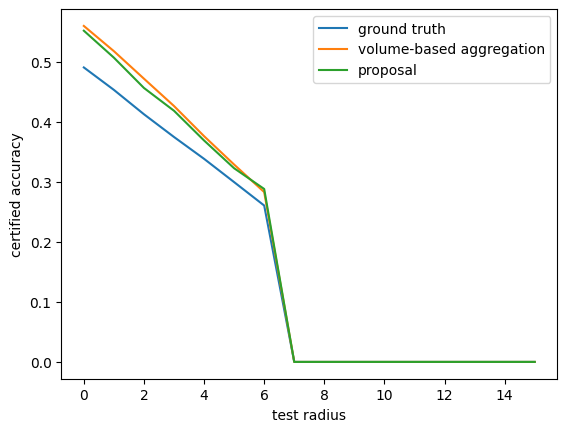

In [30]:
final_solution = 0
for solution in pp_solutions:
    final_solution = final_solution + solution
final_solution = final_solution / len(pp_solutions)
plt.clf()
plt.plot(server_cert_result, label="ground truth")
plt.plot(client_cert_result, label="volume-based aggregation")
plt.plot(final_solution, label="proposal")
plt.xlabel("test radius")
plt.ylabel("certified accuracy")

# for solution in pp_solutions:
#     plt.plot(solution)
plt.legend()

In [54]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 1.2 MB/s eta 0:00:0000:0100:01


In [32]:
import numpy as np 
import torch
A = np.load('./A_dis8_skew0.1_cifar10.npy')
num_classes = 10
num_clients = 100 
# convert numpy array to torch tensor
A = torch.from_numpy(A)

Ps = torch.ones((num_classes, 1)) * (1.0 / num_classes)

In [47]:
b =  A.sum(axis = 1)
a = [] 
for i in range(100): 
    if b[i] > 50 : 
        a.append(i) 
a

# write a function check a matrix that no column is all zeros 
def check_matrix(A) :
    for i in range(A.shape[1]) : 
        if torch.sum(A[:, i]) == 0 : 
            return False 
    return True  

for i in range(1000) : 
    # random select index from 0 to 99 to a list with no identical elements
    index = random.sample(range(100), 8)
    Pd = A / A.sum(axis=1, keepdims=True)
    Pd = Pd[index] 
    if check_matrix(Pd) :
        break 
Pd = Pd.T 

# Pd = Pd[-8:].T
# Pd  
    

tensor([[0.4444, 0.0000, 0.0000, 0.4444, 0.0000, 0.0000, 0.1111, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3077, 0.0000, 0.0000, 0.2692, 0.0000, 0.4231,
         0.0000],
        [0.3750, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6250,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3448, 0.0000, 0.3103, 0.3448, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4815, 0.1852, 0.3333, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.3000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3704, 0.0000, 0.6296, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2222, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2778],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.5000, 0.0000, 0.0000,
         0.3333]])

In [48]:
Pd.shape

torch.Size([10, 8])

In [50]:
import numpy as np
import cvxpy as cp

# Convert Pd and Ps to numpy arrays
Pd_np = Pd.detach().numpy()
Ps_np = Ps.detach().numpy()

# Create the optimization variable x
x = cp.Variable((8, 1))

# Define the objective function
objective = cp.Minimize(cp.norm2(Pd_np @ x - Ps_np))

# Define the constraints
constraints = [
    cp.sum(x) == 1,
    x >= 0,
    x <= 1
]

# Create the problem and solve it
problem = cp.Problem(objective, constraints)
problem.solve()

# Check if the problem has an optimal solution
if problem.status == 'optimal':
    # Get the values of x
    x_values = x.value
    print("Vector x:")
    print(x_values)
else:
    print("No solution found.")


Vector x:
[[2.05122018e-01]
 [1.34395325e-01]
 [1.24375688e-01]
 [5.93529194e-11]
 [1.38787006e-10]
 [2.85844848e-01]
 [1.92147190e-01]
 [5.81149305e-02]]


In [51]:
Pd_np @ x_values

array([[0.0411744 ],
       [0.10118353],
       [0.11874827],
       [0.11180203],
       [0.09778903],
       [0.09706329],
       [0.10531126],
       [0.12425577],
       [0.10524097],
       [0.09743147]])

In [37]:
A = Pd.T[:, 50 : ] > 0  

In [38]:
import torch
torch.sum(A)

tensor(0)

In [15]:
Pd.T 

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2857, 0.0000, 0.0000, 0.7143,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7273, 0.0000, 0.0000, 0.0000, 0.0000, 0.2727, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.3000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2800, 0.0000, 0.3400,
         0.3800]])

tensor([[0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0

In [14]:
import numpy as np
from scipy.optimize import minimize

# Convert Pd and Ps to numpy arrays
Pd_np = Pd.detach().numpy()
Ps_np = Ps.detach().numpy()

# Define the objective function
def objective(x):
    return np.linalg.norm(Pd_np.dot(x) - Ps_np)

# Define the constraint function
def constraint(x):
    return np.sum(x) - 1

# Define the Lagrangian function
def lagrangian(x, lambd):
    return objective(x) + lambd * constraint(x)

# Define the initial guess for x
x0 = np.ones((50, 1)) / 50

# Define the bounds for x
bounds = [(0, 1)] * 50

# Solve the problem using the Lagrangian method with bounds
res = minimize(lambda x: lagrangian(x, 1), x0, bounds=bounds, constraints={'type': 'eq', 'fun': constraint})

# Check if the problem has an optimal solution
if res.success:
    # Get the values of x
    x_values = res.x
    print("Vector x:")
    print(x_values)
    # Calculate and print the objective value
    obj_value = objective(x_values)
    print("Objective value:", obj_value)
else:
    print("No solution found.")


Vector x:
[0.0214998  0.01059308 0.01778864 0.02191414 0.03441134 0.0106575
 0.02384077 0.02460581 0.01595089 0.01826285 0.01910256 0.01766562
 0.02069684 0.01563519 0.02258966 0.01929551 0.03062885 0.03300839
 0.03260899 0.01121004 0.01773149 0.01532433 0.01294284 0.01937789
 0.02109683 0.00816278 0.01067174 0.02429188 0.00367402 0.01964887
 0.02202413 0.02868673 0.01743508 0.02973656 0.0145662  0.02019089
 0.01798064 0.01810738 0.02331127 0.0154953  0.01620346 0.0308531
 0.02247154 0.01644947 0.02141299 0.01632214 0.0240339  0.02625649
 0.02087568 0.02269791]
Objective value: 3.0000000251864094


/tmp/ipykernel_42581/844492009.py:27: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(lambda x: lagrangian(x, 1), x0, bounds=bounds, constraints={'type': 'eq', 'fun': constraint})


In [16]:
Pd_np.dot(x_values)

array([0.09998431, 0.10000063, 0.10001244, 0.09999372, 0.10000895,
       0.10000931, 0.10000227, 0.09998459, 0.10001592, 0.09998785,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     